**4 нейронных сети с разной реализацией и на разных технологиях для задачи классификации на датасете FashionMNIST. Обучение с помощью ignite**

# Сверточная сеть с аугментацией

In [1]:
!pip install pytorch-ignite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.2/343.2 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

**Первая часть ноутбука та же что и в 1/2 задаче, тк она используется для третьей задачи**

In [2]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets

from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

При возможности используем для обучения GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Загружаем датасет для обучения и тестирования. Преобразуем картинки в тензоры и сразу нормализуем их для лучшего обучения. Тренировочный датасет делим на трейновый и валидационный

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_dataset, valid_dataset = random_split(train_dataset, (0.8, 0.2))

100%|██████████| 26.4M/26.4M [00:01<00:00, 21.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 363kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.26MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.5MB/s]


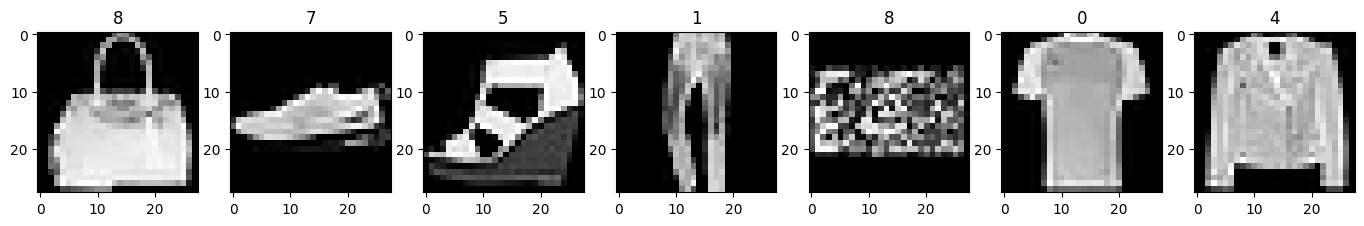

In [8]:
plt.figure(figsize=(17, 5))

for i in range(7):
  plt.subplot(1, 7, i + 1)
  plt.imshow(train_dataset[i][0][0], cmap="gray")
  plt.title(train_dataset[i][1])

plt.show()

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32)
valid_loader = DataLoader(valid_dataset, batch_size=32)

Используем полносвязную модель из линейных слоев с ф-цией relu. На выходе будут логиты после LogSoftmax чтобы использовать отрицательное правдоподобие, как лосс

In [ ]:
class FNnetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.seq = nn.Sequential(
        nn.Linear(in_features=28*28, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=10),
        nn.LogSoftmax(dim=1)
    )

  def forward(self, x):
    x = self.flatten(x)
    return self.seq(x)

In [ ]:
from torchsummary import summary

FNmodel = FNnetwork().to(device)
summary(FNmodel, (28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 256]          65,792
              ReLU-7                  [-1, 256]               0
            Linear-8                   [-1, 10]           2,570
        LogSoftmax-9                   [-1, 10]               0
Total params: 335,114
Trainable params: 335,114
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.28
Estimated Total Size (MB): 1.30
-------------------------------------------

In [ ]:
fnn_optimizer = torch.optim.SGD(FNmodel.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Используем игнайт для удобного обучения, смотря на аккуратность и лосс

In [ ]:
trainer = create_supervised_trainer(FNmodel, fnn_optimizer, criterion, device)

metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(FNmodel, metrics=metrics, device=device)
valid_evaluator = create_supervised_evaluator(FNmodel, metrics=metrics, device=device)

Выводим график лосса при обучении каждые 5 эпох, каждые 26 эпох очищаем вывод. Для начала обучим на 50 эпохах

In [ ]:
from IPython.display import clear_output

from ignite.engine import Events

def clear_screen(engine):
    clear_output()

trainer.add_event_handler(Events.EPOCH_COMPLETED(every=26), clear_screen)

def compute_epoch_results(engine):
    train_evaluator.run(train_loader)
    valid_evaluator.run(valid_loader)

trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)

def log_epoch_results(engine, label=""):
    result = ', '.join([f"{m} = {v}" for m, v in engine.state.metrics.items()])
    print(f"{label} Res:", result)

def build_plot(engine, trainer=None, epochs_for_plot=10, label=""):
    if not hasattr(build_plot, "train_loss"):
        build_plot.train_loss = []
    if not hasattr(build_plot, "valid_loss"):
        build_plot.valid_loss = []
    if label == "Train":
        build_plot.train_loss.append(engine.state.metrics["loss"])
    else:
        build_plot.valid_loss.append(engine.state.metrics["loss"])

    if trainer.state.epoch % epochs_for_plot == 0:
        plots = trainer.state.max_epochs // epochs_for_plot
        plt.figure(figsize=(12, 5 * plots));

        if label == "Valid":
            plt.subplot(plots, 2, 2 * (trainer.state.epoch // epochs_for_plot) - 1)
            plt.plot(build_plot.train_loss, color="green")
            plt.title(f"Train. epoch: {trainer.state.epoch}")

            plt.subplot(plots, 2, 2 * (trainer.state.epoch // epochs_for_plot))
            plt.plot(build_plot.valid_loss, color="red")
            plt.title(f"Valid. epoch: {trainer.state.epoch}")

        plt.show();


epochs = 50

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, build_plot, trainer=trainer, epochs_for_plot=5, label="Train")
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, build_plot, trainer=trainer, epochs_for_plot=5, label="Valid")

train_evaluator.add_event_handler(Events.COMPLETED, log_epoch_results, label="Train")
valid_evaluator.add_event_handler(Events.COMPLETED, log_epoch_results, label="Valid")

Добавляем сохранение модели

In [ ]:
from ignite.handlers import ModelCheckpoint

handler = ModelCheckpoint('/models', 'fnn', n_saved=2, create_dir=True, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=2), handler, {'first_model': FNmodel})

In [ ]:
trainer.run(train_loader, epochs); 

NameError: name 'train_loader' is not defined

Аккуратность на валидационной выборке достигла 86%, переобучения нет тк графики совпадают. Дальнейшее обучение может уменьшить лосс, но не значительно

Вывод: даже на обычной полносвязной нейросети получилось хорошо классифицировать фотографии почти в 90% правильных ответов

# Сверточная сеть

In [ ]:
class CNN(nn.Module):
    def __init__(self, classificator):
        super().__init__()
        self.flatten = nn.Flatten(-3)
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5),
            nn.ReLU(),
        )
        self.classificator = classificator # полносвязная нейронка FNmodel

    def forward(self, x):
        x = self.seq1(x)
        x = self.flatten(x)
        x = self.classificator(x)
        return x

In [ ]:
FNmodel_cnn = FNnetwork().to(device)
CNmodel = CNN(FNmodel_cnn).to(device)
summary(CNmodel, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
         MaxPool2d-3           [-1, 16, 13, 13]               0
            Conv2d-4           [-1, 16, 11, 11]           2,320
              ReLU-5           [-1, 16, 11, 11]               0
            Conv2d-6             [-1, 16, 7, 7]           6,416
              ReLU-7             [-1, 16, 7, 7]               0
           Flatten-8                  [-1, 784]               0
           Flatten-9                  [-1, 784]               0
           Linear-10                  [-1, 256]         200,960
             ReLU-11                  [-1, 256]               0
           Linear-12                  [-1, 256]          65,792
             ReLU-13                  [-1, 256]               0
           Linear-14                  [

In [ ]:
cnn_optimizer = torch.optim.SGD(CNmodel.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Используем игнайт для удобного обучения как и с первой моделью

In [ ]:
trainer = create_supervised_trainer(CNmodel, cnn_optimizer, criterion, device)

metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(CNmodel, metrics=metrics, device=device)
valid_evaluator = create_supervised_evaluator(CNmodel, metrics=metrics, device=device)

Подключаем уже написанные функции для первой модели. Для начала обучим на 50 эпохах

In [ ]:
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=26), clear_screen)
trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)

epochs = 50

del build_plot.train_loss # обновляем массивы для построения графиков
del build_plot.valid_loss

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, build_plot, trainer=trainer, epochs_for_plot=5, label="Train")
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, build_plot, trainer=trainer, epochs_for_plot=5, label="Valid")

train_evaluator.add_event_handler(Events.COMPLETED, log_epoch_results, label="Train")
valid_evaluator.add_event_handler(Events.COMPLETED, log_epoch_results, label="Valid")

Добавляем сохранение модели

In [ ]:
handler = ModelCheckpoint('/models', 'cnn', n_saved=2, create_dir=True, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=2), handler, {'first_model': CNmodel})

Train Res: accuracy = 0.7830625, loss = 0.5746359049479167
Valid Res: accuracy = 0.78325, loss = 0.57237939453125
Train Res: accuracy = 0.78825, loss = 0.5613706868489583
Valid Res: accuracy = 0.7885, loss = 0.5595229899088542
Train Res: accuracy = 0.7931666666666667, loss = 0.5485082600911458
Valid Res: accuracy = 0.7930833333333334, loss = 0.5469813639322917
Train Res: accuracy = 0.7990208333333333, loss = 0.5372676188151042
Valid Res: accuracy = 0.7973333333333333, loss = 0.5359996337890625


<Figure size 1200x5000 with 0 Axes>

Train Res: accuracy = 0.803125, loss = 0.5275255126953124


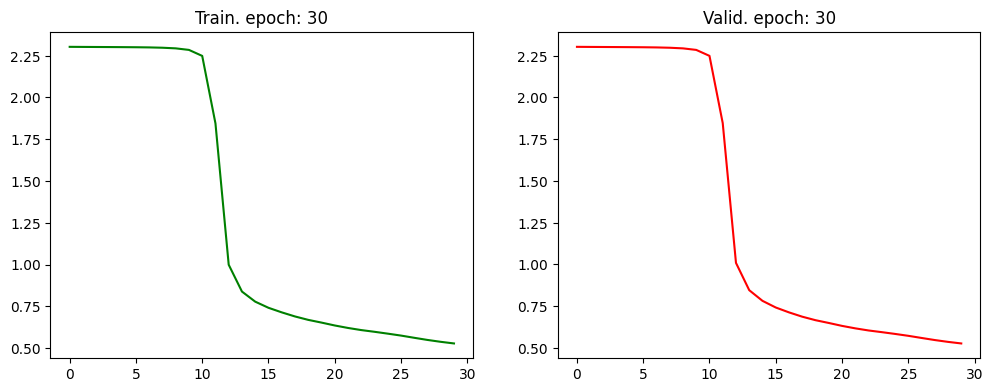

Valid Res: accuracy = 0.8, loss = 0.5266039632161459
Train Res: accuracy = 0.8070625, loss = 0.5163221842447917
Valid Res: accuracy = 0.8050833333333334, loss = 0.5158670654296875
Train Res: accuracy = 0.8113333333333334, loss = 0.5055458984375
Valid Res: accuracy = 0.8105, loss = 0.5055898030598959
Train Res: accuracy = 0.8147916666666667, loss = 0.4952832845052083
Valid Res: accuracy = 0.8133333333333334, loss = 0.49601554361979167
Train Res: accuracy = 0.8188333333333333, loss = 0.4851265869140625
Valid Res: accuracy = 0.818, loss = 0.4865793050130208


<Figure size 1200x5000 with 0 Axes>

Train Res: accuracy = 0.8225, loss = 0.4752929280598958


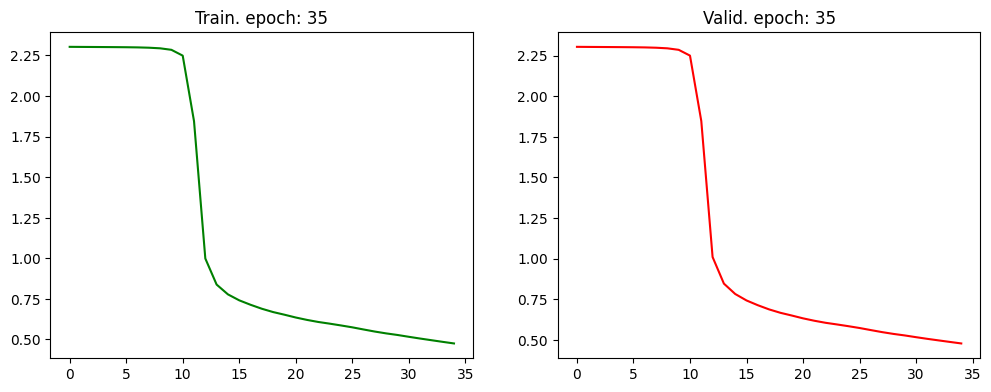

Valid Res: accuracy = 0.8203333333333334, loss = 0.47728153483072916
Train Res: accuracy = 0.8251875, loss = 0.46671805826822915
Valid Res: accuracy = 0.8229166666666666, loss = 0.4692545979817708
Train Res: accuracy = 0.8270208333333333, loss = 0.4593837483723958
Valid Res: accuracy = 0.82475, loss = 0.46234159342447917
Train Res: accuracy = 0.8296041666666667, loss = 0.4526561686197917
Valid Res: accuracy = 0.82675, loss = 0.4561300862630208
Train Res: accuracy = 0.8324791666666667, loss = 0.4451346842447917
Valid Res: accuracy = 0.8306666666666667, loss = 0.4490467122395833


<Figure size 1200x5000 with 0 Axes>

Train Res: accuracy = 0.8360833333333333, loss = 0.43785396321614584


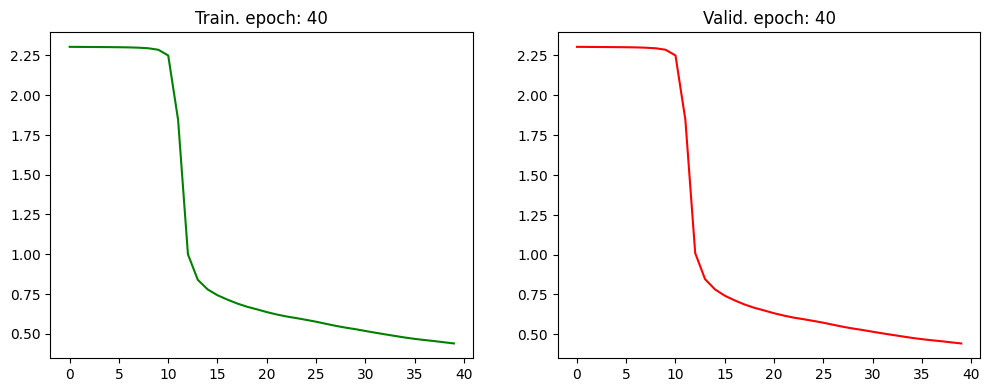

Valid Res: accuracy = 0.83275, loss = 0.44230997721354165
Train Res: accuracy = 0.8381458333333334, loss = 0.431770263671875
Valid Res: accuracy = 0.835, loss = 0.436999755859375
Train Res: accuracy = 0.8408958333333333, loss = 0.4258672688802083
Valid Res: accuracy = 0.8378333333333333, loss = 0.43165641276041666
Train Res: accuracy = 0.8432291666666667, loss = 0.4196009521484375
Valid Res: accuracy = 0.8400833333333333, loss = 0.42606461588541666
Train Res: accuracy = 0.8452083333333333, loss = 0.4145198160807292
Valid Res: accuracy = 0.84225, loss = 0.42154890950520835


<Figure size 1200x5000 with 0 Axes>

Train Res: accuracy = 0.8471041666666667, loss = 0.40985847981770834


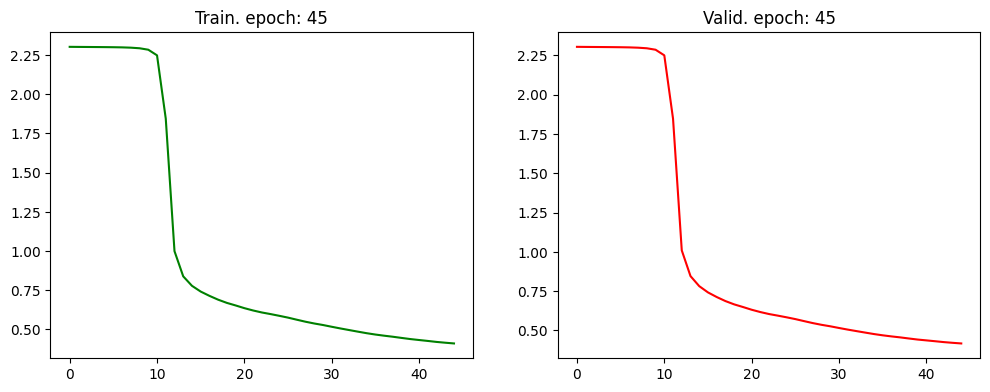

Valid Res: accuracy = 0.8434166666666667, loss = 0.41751155598958334
Train Res: accuracy = 0.8495416666666666, loss = 0.4037225341796875
Valid Res: accuracy = 0.8465, loss = 0.41206144205729167
Train Res: accuracy = 0.8507083333333333, loss = 0.39944771321614586
Valid Res: accuracy = 0.8485, loss = 0.40854447428385415
Train Res: accuracy = 0.8526875, loss = 0.3944043375651042
Valid Res: accuracy = 0.8499166666666667, loss = 0.40400309244791666
Train Res: accuracy = 0.8541458333333334, loss = 0.39071875
Valid Res: accuracy = 0.8518333333333333, loss = 0.4009583740234375


<Figure size 1200x5000 with 0 Axes>

Train Res: accuracy = 0.85625, loss = 0.38581465657552083


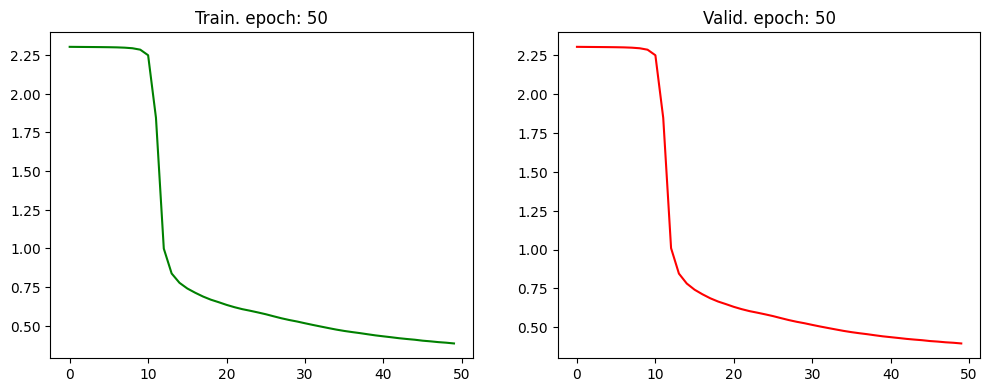

Valid Res: accuracy = 0.854, loss = 0.3965836588541667


In [ ]:
trainer.run(train_loader, epochs);

График явно еще недостаточно прямой, а значит последующее обучение даст хороший прирост к аккуратности

Train Res: accuracy = 0.8848333333333334, loss = 0.310886474609375
Valid Res: accuracy = 0.8744166666666666, loss = 0.3392269694010417
Train Res: accuracy = 0.8858125, loss = 0.30844209798177086
Valid Res: accuracy = 0.8753333333333333, loss = 0.3375277506510417
Train Res: accuracy = 0.886125, loss = 0.3067193806966146
Valid Res: accuracy = 0.8765833333333334, loss = 0.3365368041992188
Train Res: accuracy = 0.8865, loss = 0.3049608561197917
Valid Res: accuracy = 0.8769166666666667, loss = 0.33597027587890627


<Figure size 1200x5000 with 0 Axes>

Train Res: accuracy = 0.8872291666666666, loss = 0.30343013509114586


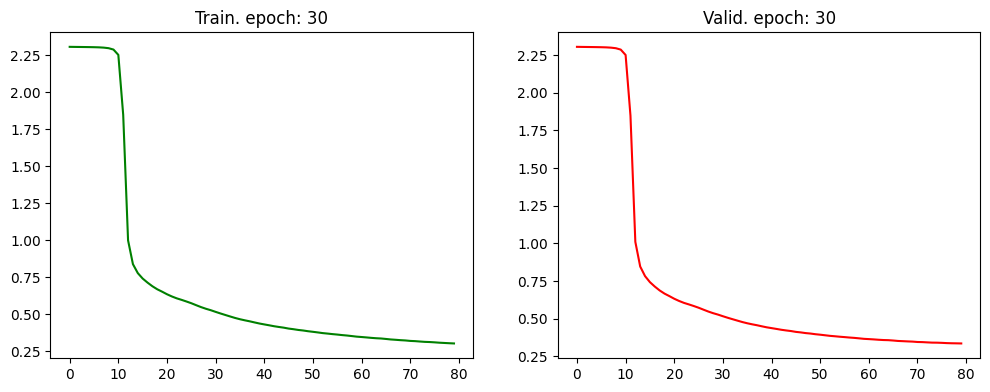

Valid Res: accuracy = 0.8771666666666667, loss = 0.33525823974609376
Train Res: accuracy = 0.8879583333333333, loss = 0.30099875895182293
Valid Res: accuracy = 0.8780833333333333, loss = 0.3335390218098958
Train Res: accuracy = 0.888875, loss = 0.29861263020833334
Valid Res: accuracy = 0.8788333333333334, loss = 0.3320270589192708
Train Res: accuracy = 0.8895416666666667, loss = 0.2963359171549479
Valid Res: accuracy = 0.87925, loss = 0.33072052001953123
Train Res: accuracy = 0.8899791666666667, loss = 0.29485847981770835
Valid Res: accuracy = 0.8801666666666667, loss = 0.33013968912760416


<Figure size 1200x5000 with 0 Axes>

Train Res: accuracy = 0.8907291666666667, loss = 0.2923082478841146


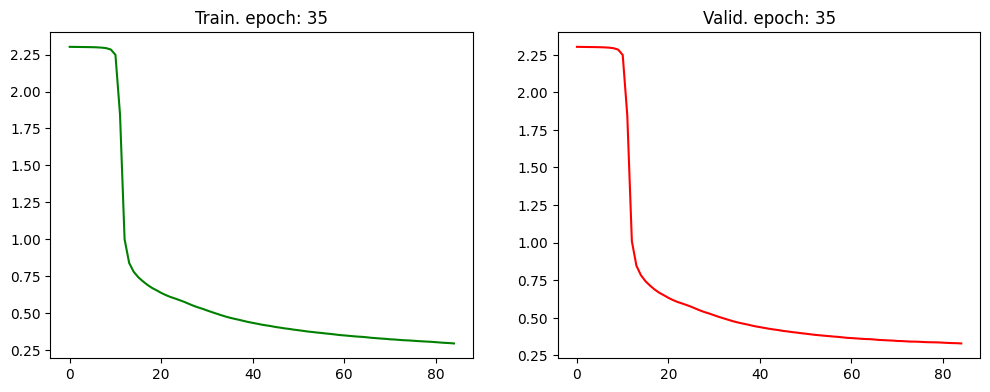

Valid Res: accuracy = 0.8811666666666667, loss = 0.3283903401692708
Train Res: accuracy = 0.8916041666666666, loss = 0.29046061197916667
Valid Res: accuracy = 0.8815833333333334, loss = 0.32737967936197915
Train Res: accuracy = 0.8923958333333334, loss = 0.28806703694661456
Valid Res: accuracy = 0.8829166666666667, loss = 0.32587738037109376
Train Res: accuracy = 0.8936041666666666, loss = 0.2855498046875
Valid Res: accuracy = 0.8835, loss = 0.3241265055338542
Train Res: accuracy = 0.8937916666666667, loss = 0.28450679524739586
Valid Res: accuracy = 0.8831666666666667, loss = 0.3239075927734375


<Figure size 1200x5000 with 0 Axes>

Train Res: accuracy = 0.8944166666666666, loss = 0.28243868001302086


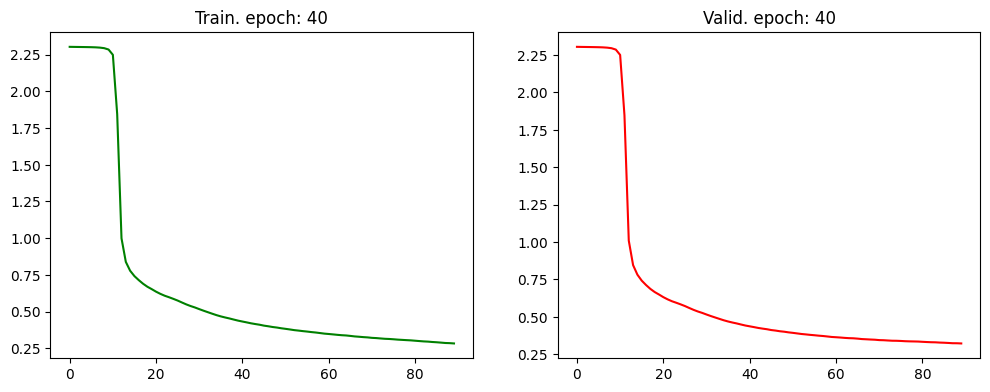

Valid Res: accuracy = 0.8840833333333333, loss = 0.32258050537109373
Train Res: accuracy = 0.8950208333333334, loss = 0.2813470255533854
Valid Res: accuracy = 0.8839166666666667, loss = 0.3224365030924479
Train Res: accuracy = 0.8951458333333333, loss = 0.2802630818684896
Valid Res: accuracy = 0.8845833333333334, loss = 0.3221521606445312
Train Res: accuracy = 0.8959166666666667, loss = 0.2783278605143229
Valid Res: accuracy = 0.8845, loss = 0.3209882609049479
Train Res: accuracy = 0.8964791666666667, loss = 0.2769771321614583
Valid Res: accuracy = 0.8846666666666667, loss = 0.3203576253255208


<Figure size 1200x5000 with 0 Axes>

Train Res: accuracy = 0.8973333333333333, loss = 0.2749389851888021


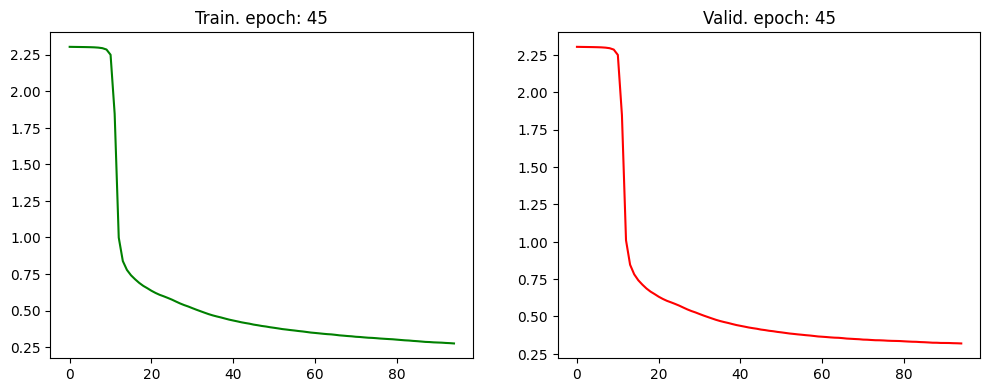

Valid Res: accuracy = 0.8851666666666667, loss = 0.3192235107421875
Train Res: accuracy = 0.8981041666666667, loss = 0.27258308919270835
Valid Res: accuracy = 0.8859166666666667, loss = 0.3172289225260417
Train Res: accuracy = 0.8985208333333333, loss = 0.27107694498697915
Valid Res: accuracy = 0.8859166666666667, loss = 0.31679667154947916
Train Res: accuracy = 0.8990625, loss = 0.2697444864908854
Valid Res: accuracy = 0.88625, loss = 0.31613175455729164
Train Res: accuracy = 0.8993333333333333, loss = 0.26800063069661456
Valid Res: accuracy = 0.8868333333333334, loss = 0.3152113037109375


<Figure size 1200x5000 with 0 Axes>

Train Res: accuracy = 0.9000625, loss = 0.2670575968424479


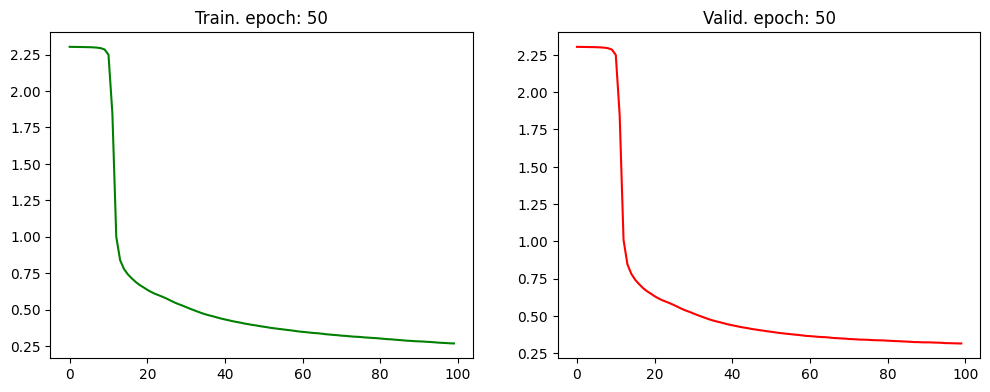

Valid Res: accuracy = 0.88675, loss = 0.31503883870442706


State:
	iteration: 75000
	epoch: 50
	epoch_length: 1500
	max_epochs: 50
	output: 0.24701079726219177
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [ ]:
trainer.run(train_loader, epochs)

Вывод: сверточная сеть трудней обучаема, но дала результат выше обычной

# Сверточная сеть с аугментацией

In [ ]:
from torchvision.transforms.v2 import RandomHorizontalFlip, ToDtype, RandomVerticalFlip, Grayscale

transform_aug = transforms.Compose([
    RandomHorizontalFlip(1.0),
    RandomVerticalFlip(1.0),
    transforms.ToTensor(),
    ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset_aug = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_aug) # изначально используется обычный трансформатор
valid_dataset_aug = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_aug = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_dataset1 = random_split(train_dataset_aug, (0.7, 0.3))[0]
train_dataset_aug, valid_dataset_aug = random_split(valid_dataset_aug, (0.7, 0.3))

Объединяем датасет для тренировки с аугментацией и без

In [ ]:
from torch.utils.data import ConcatDataset

train_dataset_aug = ConcatDataset((train_dataset_aug, train_dataset1))

In [ ]:
from torch.utils.data import Dataset

class AugDataset(Dataset):
    def __init__(self, subset):
        self.subset = subset

    def __getitem__(self, index):
        x, y = self.subset[index % len(self.subset)]
        if index > len(self.subset):
            x = transform_aug(x)
        else:
            x = transform(x)
        return x, y

    def __len__(self):
        return len(self.subset) * 2

class ValDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

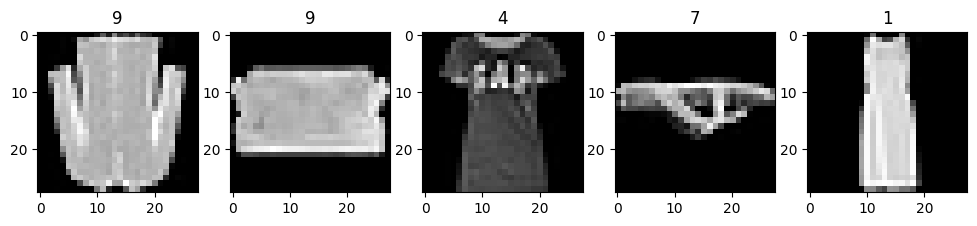

In [ ]:
import numpy as np

plt.figure(figsize=(12, 5))

for i in range(5):
  plt.subplot(1, 5, i + 1)
  plt.imshow(train_dataset_aug[np.random.randint(0, len(train_dataset_aug))][0].squeeze(), cmap="gray")
  plt.title(train_dataset_aug[i][1])

plt.show()

In [ ]:
train_loader_aug = DataLoader(train_dataset_aug, batch_size=16, shuffle=True)
valid_loader_aug = DataLoader(valid_dataset_aug, batch_size=16)

Модифицируем CNN модель добавив регуляризации, ввиде дропаута для сверточных слоев, то есть 2d

In [ ]:
class CNN_2(nn.Module):
    def __init__(self, classificator):
        super().__init__()
        self.flatten = nn.Flatten(-3)
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.Dropout2d(p=0.15),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.Dropout2d(p=0.1),
        )
        self.classificator = classificator # полносвязная нейронка FNmodel

    def forward(self, x):
        x = self.seq1(x)
        x = self.flatten(x)
        x = self.classificator(x)
        return x

In [ ]:
FNmodel_cnn_aug = FNnetwork().to(device)
CNmodel_aug = CNN_2(FNmodel_cnn_aug).to(device)
summary(CNmodel_aug, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
         Dropout2d-3           [-1, 16, 26, 26]               0
         MaxPool2d-4           [-1, 16, 13, 13]               0
            Conv2d-5           [-1, 16, 11, 11]           2,320
              ReLU-6           [-1, 16, 11, 11]               0
            Conv2d-7             [-1, 16, 7, 7]           6,416
              ReLU-8             [-1, 16, 7, 7]               0
         Dropout2d-9             [-1, 16, 7, 7]               0
          Flatten-10                  [-1, 784]               0
          Flatten-11                  [-1, 784]               0
           Linear-12                  [-1, 256]         200,960
             ReLU-13                  [-1, 256]               0
           Linear-14                  [

Используем игнайт для удобного обучения как и с первой моделью

In [ ]:
cnn_optimizer_aug = torch.optim.SGD(CNmodel_aug.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
trainer = create_supervised_trainer(CNmodel_aug, cnn_optimizer_aug, criterion, device)

metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(CNmodel_aug, metrics=metrics, device=device)
valid_evaluator = create_supervised_evaluator(CNmodel_aug, metrics=metrics, device=device)

Подключаем уже написанные функции для первой модели. Для начала обучим на 50 эпохах

In [ ]:
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=26), clear_screen)

def compute_epoch_results_aug(engine):
    train_evaluator.run(train_loader_aug)
    valid_evaluator.run(valid_loader_aug)

trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results_aug)

epochs = 75

if hasattr(build_plot, "train_loss"):   # обновляем массивы для построения графиков
    del build_plot.train_loss
if hasattr(build_plot, "valid_loss"):
    del build_plot.valid_loss

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, build_plot, trainer=trainer, epochs_for_plot=5, label="Train")
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, build_plot, trainer=trainer, epochs_for_plot=5, label="Valid")

train_evaluator.add_event_handler(Events.COMPLETED, log_epoch_results, label="Train")
valid_evaluator.add_event_handler(Events.COMPLETED, log_epoch_results, label="Valid")

Добавляем сохранение модели

In [ ]:
handler = ModelCheckpoint('/models', 'cnn_aug', n_saved=2, create_dir=True, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=2), handler, {'first_model': CNmodel_aug})

Train Res: accuracy = 0.9030238095238096, loss = 0.25940397135416665
Valid Res: accuracy = 0.8833888888888889, loss = 0.3289013943142361
Train Res: accuracy = 0.9050238095238096, loss = 0.2532389555431548
Valid Res: accuracy = 0.8873888888888889, loss = 0.31391908094618054
Train Res: accuracy = 0.9086785714285714, loss = 0.24526864769345239
Valid Res: accuracy = 0.8893888888888889, loss = 0.3089880913628472


<Figure size 1200x7500 with 0 Axes>

Train Res: accuracy = 0.9092976190476191, loss = 0.24140536644345237


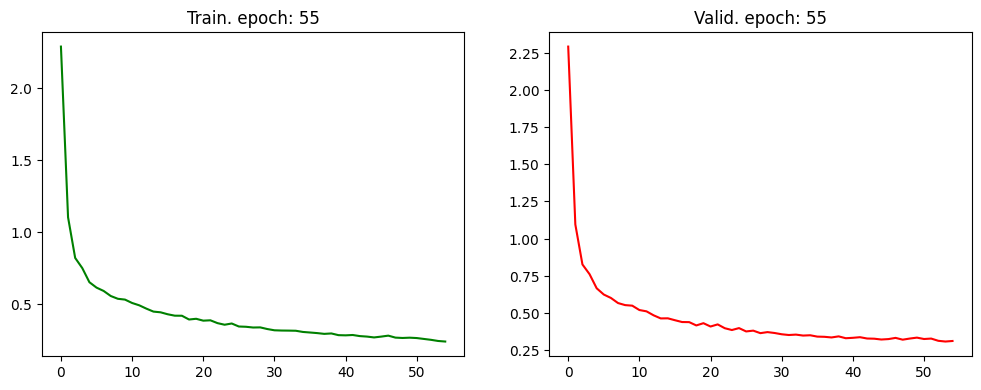

Valid Res: accuracy = 0.8870555555555556, loss = 0.3126461046006944
Train Res: accuracy = 0.909952380952381, loss = 0.24154871186755952
Valid Res: accuracy = 0.8886111111111111, loss = 0.31662288411458334
Train Res: accuracy = 0.9093214285714286, loss = 0.24559014601934523
Valid Res: accuracy = 0.8846111111111111, loss = 0.3269609917534722
Train Res: accuracy = 0.9094285714285715, loss = 0.24289099702380954
Valid Res: accuracy = 0.8863333333333333, loss = 0.3181569281684028
Train Res: accuracy = 0.9131666666666667, loss = 0.23419149925595237
Valid Res: accuracy = 0.8907222222222222, loss = 0.3098734809027778


<Figure size 1200x7500 with 0 Axes>

Train Res: accuracy = 0.912702380952381, loss = 0.23232280040922618


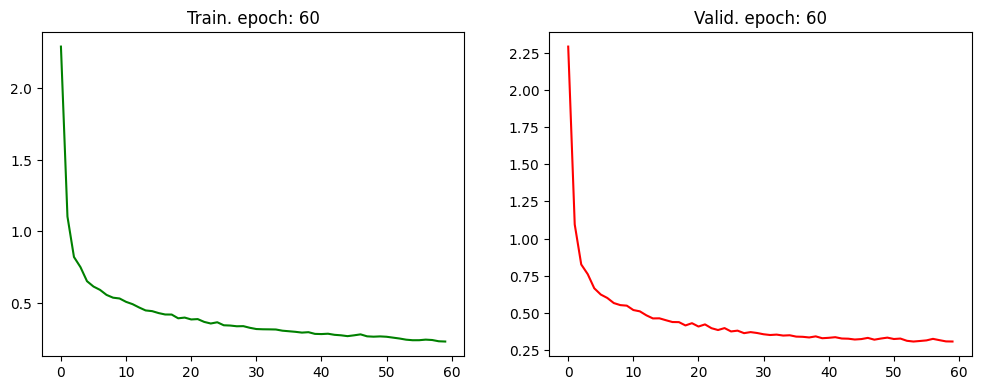

Valid Res: accuracy = 0.89, loss = 0.30911417643229167
Train Res: accuracy = 0.9145357142857143, loss = 0.22888792782738096
Valid Res: accuracy = 0.891, loss = 0.3073977322048611
Train Res: accuracy = 0.9146904761904762, loss = 0.22739199683779762
Valid Res: accuracy = 0.8918333333333334, loss = 0.3031559787326389
Train Res: accuracy = 0.9120714285714285, loss = 0.23283344959077382
Valid Res: accuracy = 0.8891111111111111, loss = 0.3152414822048611
Train Res: accuracy = 0.9143214285714286, loss = 0.23081963820684523
Valid Res: accuracy = 0.8867777777777778, loss = 0.3179513617621528


<Figure size 1200x7500 with 0 Axes>

Train Res: accuracy = 0.9137142857142857, loss = 0.2299570777529762


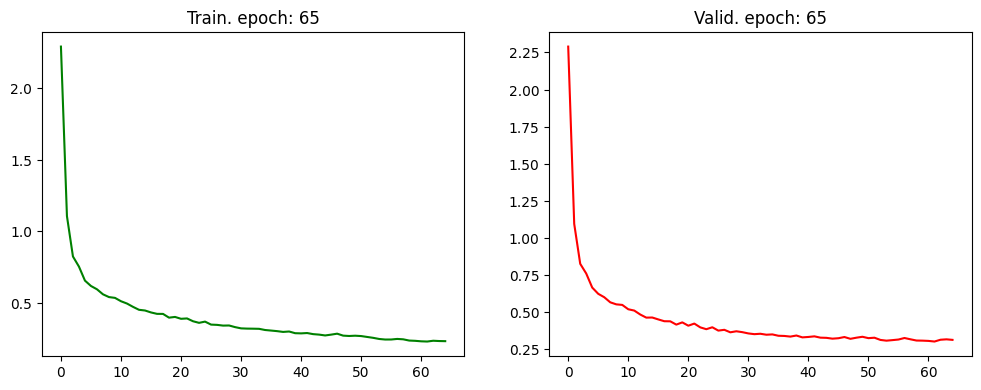

Valid Res: accuracy = 0.8882222222222222, loss = 0.31433243815104167
Train Res: accuracy = 0.9176428571428571, loss = 0.22217613002232142
Valid Res: accuracy = 0.8901111111111111, loss = 0.30808200412326386
Train Res: accuracy = 0.9217142857142857, loss = 0.21401664806547618
Valid Res: accuracy = 0.8910555555555556, loss = 0.30367472330729167
Train Res: accuracy = 0.9174166666666667, loss = 0.21811739676339287
Valid Res: accuracy = 0.8899444444444444, loss = 0.3201872016059028
Train Res: accuracy = 0.9172857142857143, loss = 0.2175556640625
Valid Res: accuracy = 0.8903333333333333, loss = 0.3072857259114583


<Figure size 1200x7500 with 0 Axes>

Train Res: accuracy = 0.9219285714285714, loss = 0.20893098958333334


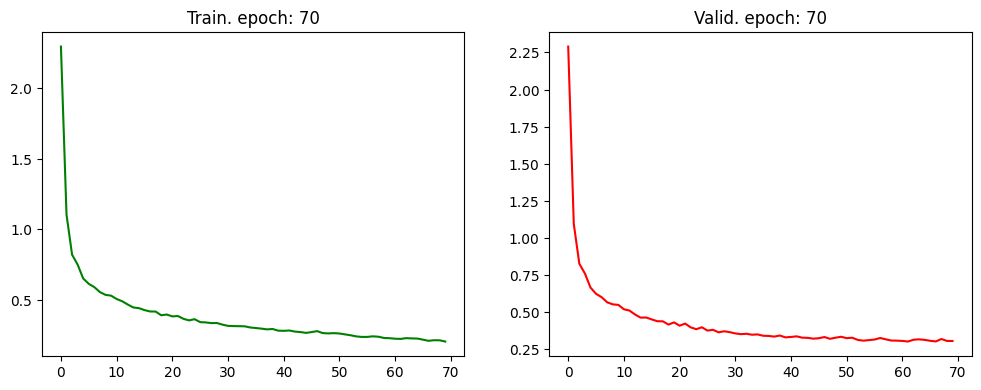

Valid Res: accuracy = 0.8913333333333333, loss = 0.30678531901041667
Train Res: accuracy = 0.9211666666666667, loss = 0.20871756417410714
Valid Res: accuracy = 0.8915555555555555, loss = 0.2986025661892361
Train Res: accuracy = 0.9178095238095239, loss = 0.21495226469494047
Valid Res: accuracy = 0.8861111111111111, loss = 0.3268847927517361
Train Res: accuracy = 0.9261785714285714, loss = 0.20128294735863095
Valid Res: accuracy = 0.8951666666666667, loss = 0.2985693630642361
Train Res: accuracy = 0.9241071428571429, loss = 0.20187555803571428
Valid Res: accuracy = 0.8937777777777778, loss = 0.3059295518663194


<Figure size 1200x7500 with 0 Axes>

Train Res: accuracy = 0.9224404761904762, loss = 0.20530508277529763


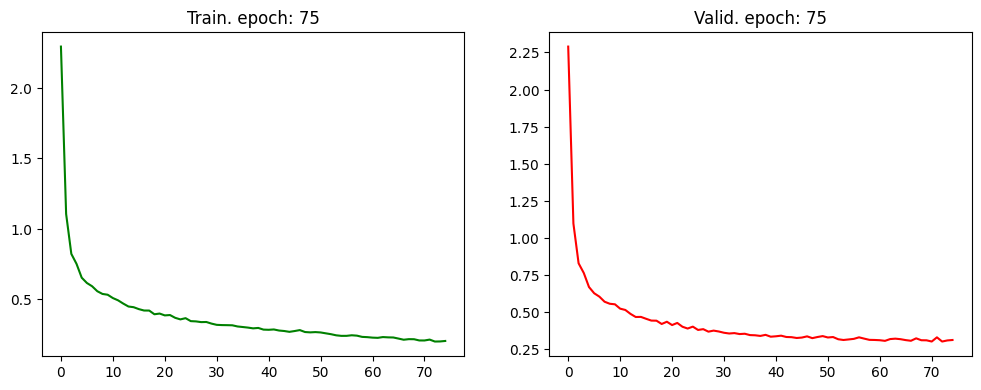

Valid Res: accuracy = 0.8917222222222222, loss = 0.3089460177951389


In [ ]:
trainer.run(train_loader_aug, epochs);

Вывод: аугментация не особо прибавила точности предсказания, но по сути улучшила обобщающую способность, если бы тестовые данные были более зашумленные, то модель натренированная на аугментации лучше бы справилась чем без

# Сверточная сеть с скип коннекшеном

Модифицируем CNN модель добавив skip connection. Создадим отдельный класс блоков, состоящий из двух сверточных слоев и будем входной слой прибавлять к выходу блока. Использовав в нейросети 2 таких блока получим сеть по архитектуре похожую на 2 задачу

In [ ]:
class Block2d(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, kernel=3, is_batch_norm=False):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.1),
        )
        self.is_batch_norm = is_batch_norm
        if is_batch_norm:
            self.norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.1),
        )
        if is_batch_norm:
            self.norm2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1), # делаем выходных ядер столько же сколько и после двух слоев, не изменяя размерности
            nn.BatchNorm2d(out_channels)
        )


    def forward(self, x):
        residual = self.skip(x)
        out = self.conv1(x)
        if self.is_batch_norm:
            out = self.norm1(out)
        out = self.conv2(out)
        if self.is_batch_norm:
            out = self.norm2(out)

        out += residual # skip connection
        return out

class CNN_sc(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten(-3)
        self.conv_blocks = nn.Sequential(
            Block2d(1, 16).to(device),
            nn.MaxPool2d(2, 2),

            Block2d(16, 16).to(device),
            nn.MaxPool2d(2, 2)
        )
        self.classificator = FNnetwork().to(device)

    def forward(self, x):
        out = self.conv_blocks(x)
        out = self.flatten(out)
        out = self.classificator(out)
        return out

In [ ]:
bl = Block2d(1, 16, 3).to(device) # проверяем на сходство размеров одного блока
summary(bl, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]              32
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3           [-1, 16, 28, 28]             160
              ReLU-4           [-1, 16, 28, 28]               0
         Dropout2d-5           [-1, 16, 28, 28]               0
            Conv2d-6           [-1, 16, 28, 28]           2,320
              ReLU-7           [-1, 16, 28, 28]               0
         Dropout2d-8           [-1, 16, 28, 28]               0
Total params: 2,544
Trainable params: 2,544
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.77
Params size (MB): 0.01
Estimated Total Size (MB): 0.78
----------------------------------------------------------------


In [ ]:
CNmodel_sc = CNN_sc().to(device)
summary(CNmodel_sc, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]              32
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3           [-1, 16, 28, 28]             160
              ReLU-4           [-1, 16, 28, 28]               0
         Dropout2d-5           [-1, 16, 28, 28]               0
            Conv2d-6           [-1, 16, 28, 28]           2,320
              ReLU-7           [-1, 16, 28, 28]               0
         Dropout2d-8           [-1, 16, 28, 28]               0
           Block2d-9           [-1, 16, 28, 28]               0
        MaxPool2d-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]             272
      BatchNorm2d-12           [-1, 16, 14, 14]              32
           Conv2d-13           [-1, 16, 14, 14]           2,320
             ReLU-14           [-1, 16,

Используем игнайт для удобного обучения как и с первой моделью

In [ ]:
cnn_optimizer_sc = torch.optim.SGD(CNmodel_sc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
trainer = create_supervised_trainer(CNmodel_sc, cnn_optimizer_sc, criterion, device)

metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(CNmodel_sc, metrics=metrics, device=device)
valid_evaluator = create_supervised_evaluator(CNmodel_sc, metrics=metrics, device=device)

Подключаем уже написанные функции для первой модели. Для начала обучим на 75 эпохах

In [ ]:
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=26), clear_screen)

trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)

epochs = 75

if hasattr(build_plot, "train_loss"):   # обновляем массивы для построения графиков
    del build_plot.train_loss
if hasattr(build_plot, "valid_loss"):
    del build_plot.valid_loss

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, build_plot, trainer=trainer, epochs_for_plot=5, label="Train")
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, build_plot, trainer=trainer, epochs_for_plot=5, label="Valid")

train_evaluator.add_event_handler(Events.COMPLETED, log_epoch_results, label="Train")
valid_evaluator.add_event_handler(Events.COMPLETED, log_epoch_results, label="Valid")

Добавляем сохранение модели

In [ ]:
from ignite.handlers import ModelCheckpoint

handler = ModelCheckpoint('/models', 'cnn_sc', n_saved=2, create_dir=True, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=2), handler, {'first_model': CNmodel_sc})

Train Res: accuracy = 0.908375, loss = 0.255384033203125
Valid Res: accuracy = 0.8944166666666666, loss = 0.2912972412109375
Train Res: accuracy = 0.9094583333333334, loss = 0.2531707967122396
Valid Res: accuracy = 0.8971666666666667, loss = 0.2888452962239583
Train Res: accuracy = 0.9092916666666667, loss = 0.25162933349609373
Valid Res: accuracy = 0.8959166666666667, loss = 0.28850164794921873


<Figure size 1200x7500 with 0 Axes>

Train Res: accuracy = 0.9108333333333334, loss = 0.24755094401041666


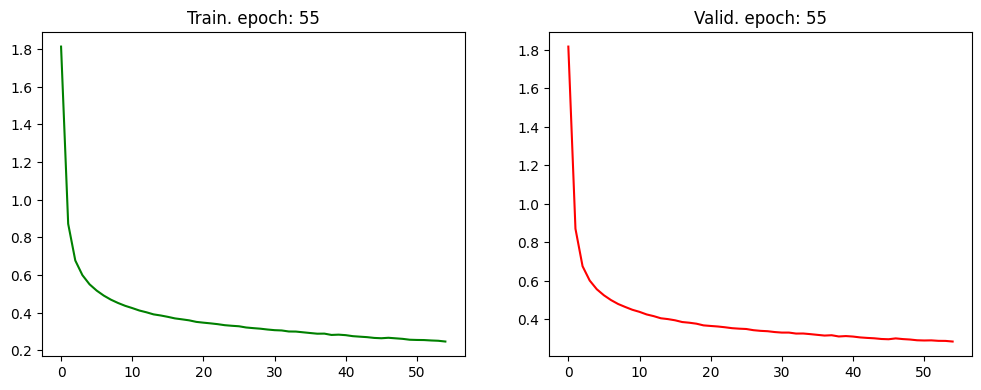

Valid Res: accuracy = 0.8980833333333333, loss = 0.2852540079752604
Train Res: accuracy = 0.9105208333333333, loss = 0.2489354044596354
Valid Res: accuracy = 0.8973333333333333, loss = 0.2867357177734375
Train Res: accuracy = 0.9126458333333334, loss = 0.24381711832682293
Valid Res: accuracy = 0.8999166666666667, loss = 0.28288543701171875
Train Res: accuracy = 0.913375, loss = 0.24061745198567708
Valid Res: accuracy = 0.9001666666666667, loss = 0.28011077880859375
Train Res: accuracy = 0.9137291666666667, loss = 0.2390938720703125
Valid Res: accuracy = 0.901, loss = 0.2785713297526042


<Figure size 1200x7500 with 0 Axes>

Train Res: accuracy = 0.9150208333333333, loss = 0.23690352376302085


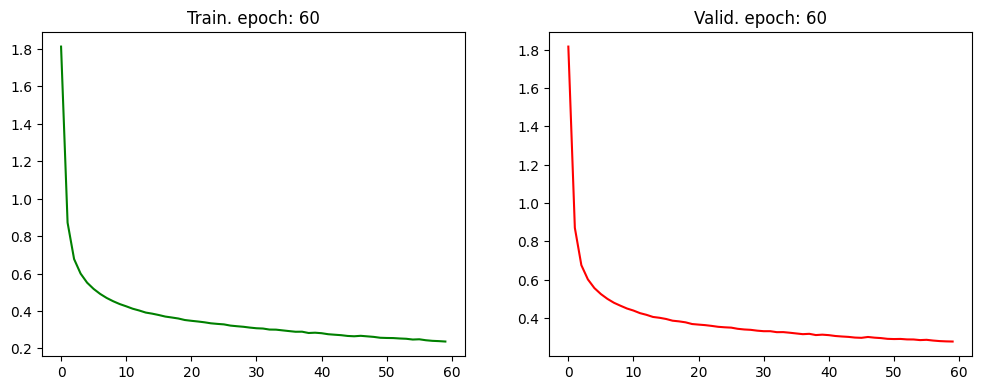

Valid Res: accuracy = 0.902, loss = 0.27777923583984376
Train Res: accuracy = 0.9161666666666667, loss = 0.23426259358723958
Valid Res: accuracy = 0.9025833333333333, loss = 0.27556829833984375
Train Res: accuracy = 0.916, loss = 0.2352353515625
Valid Res: accuracy = 0.90125, loss = 0.27746549479166666
Train Res: accuracy = 0.9168333333333333, loss = 0.23198974609375
Valid Res: accuracy = 0.9030833333333333, loss = 0.27495090738932293
Train Res: accuracy = 0.9175833333333333, loss = 0.22907729085286457
Valid Res: accuracy = 0.9045833333333333, loss = 0.27220674641927084


<Figure size 1200x7500 with 0 Axes>

Train Res: accuracy = 0.9188125, loss = 0.22726837158203125


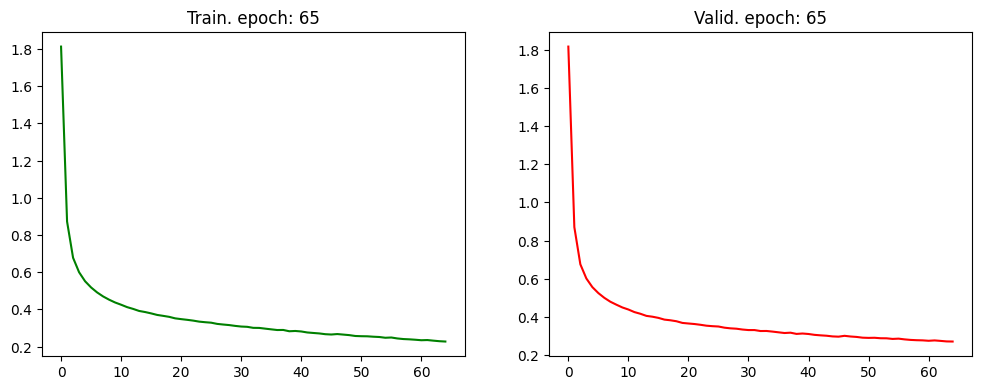

Valid Res: accuracy = 0.90375, loss = 0.271629638671875
Train Res: accuracy = 0.918625, loss = 0.22628184000651042
Valid Res: accuracy = 0.9048333333333334, loss = 0.27053511555989584
Train Res: accuracy = 0.9181875, loss = 0.22757771809895833
Valid Res: accuracy = 0.9055833333333333, loss = 0.27232991536458334
Train Res: accuracy = 0.9192083333333333, loss = 0.22418680826822918
Valid Res: accuracy = 0.9056666666666666, loss = 0.2703474527994792
Train Res: accuracy = 0.920125, loss = 0.22215425618489584
Valid Res: accuracy = 0.9066666666666666, loss = 0.2675963134765625


<Figure size 1200x7500 with 0 Axes>

Train Res: accuracy = 0.9214583333333334, loss = 0.21966746012369792


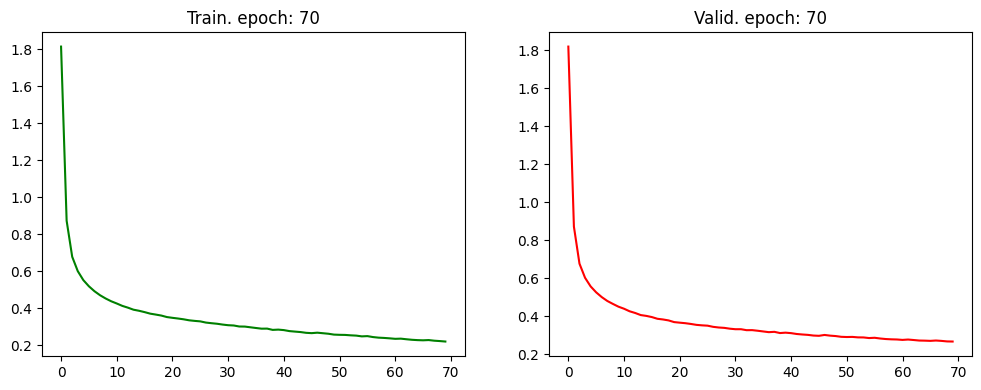

Valid Res: accuracy = 0.907, loss = 0.2670163981119792
Train Res: accuracy = 0.9213958333333333, loss = 0.21960496012369793
Valid Res: accuracy = 0.9068333333333334, loss = 0.26783058675130206
Train Res: accuracy = 0.9219791666666667, loss = 0.21856630452473957
Valid Res: accuracy = 0.9065, loss = 0.26742293294270836
Train Res: accuracy = 0.9232083333333333, loss = 0.21564947509765625
Valid Res: accuracy = 0.9073333333333333, loss = 0.264716064453125
Train Res: accuracy = 0.9224375, loss = 0.21749704996744793
Valid Res: accuracy = 0.90525, loss = 0.2674611612955729


<Figure size 1200x7500 with 0 Axes>

Train Res: accuracy = 0.9230625, loss = 0.21545174153645832


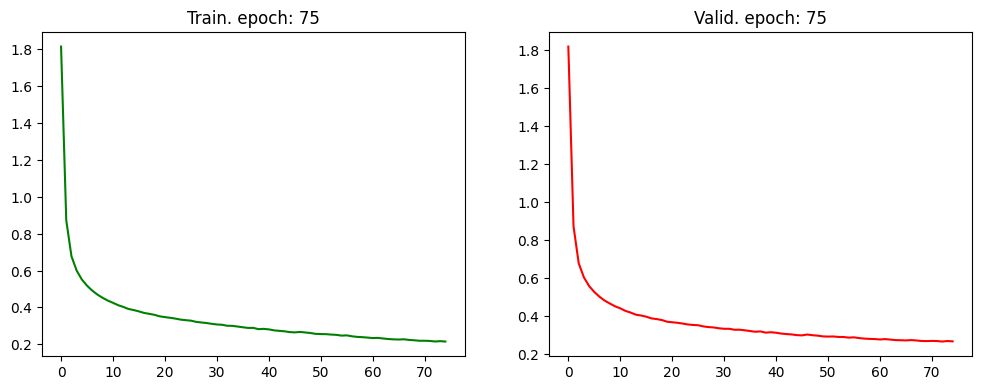

Valid Res: accuracy = 0.9065, loss = 0.26557769775390627


In [ ]:
trainer.run(train_loader, epochs);

Вывод: skip connection сильно ускорил обучение, тк не было начального простоя, когда градиенты плохо обновляли веса для глубоких слоев. Это видно по графикам, во второй задаче и третьей, график имеет сначала стабильный лосс и только потом медленно начинает падать. Здесь же метрики растут вначале довольно резко